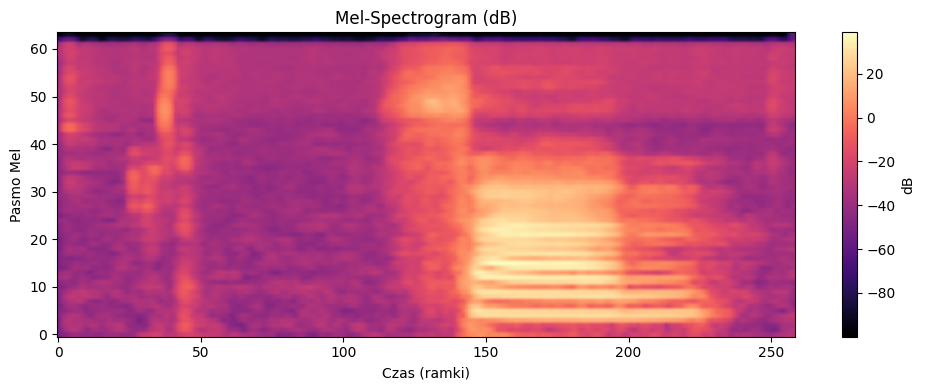

In [1]:
import torchaudio
from pydub import AudioSegment
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Konwersja .ogg do .wav
audio = AudioSegment.from_file('../recordings/stageI/21/a3.ogg')
audio.export("output2.wav", format="wav")

# Wczytaj audio i oblicz mel-spectrogram
waveform, sr = torchaudio.load("output2.wav")
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=sr,
    n_fft=2048,
    hop_length=256,
    n_mels=64
)(waveform)

# Konwersja do numpy i skala dB
mel_spec_np = mel_spec[0].cpu().detach().numpy()
mel_spec_db = 10 * np.log10(mel_spec_np + 1e-10)  # unikamy log(0)

# Rysowanie wykresu
plt.figure(figsize=(10, 4))
plt.imshow(mel_spec_db, origin='lower', aspect='auto', cmap='magma')
plt.title('Mel-Spectrogram (dB)')
plt.xlabel('Czas (ramki)')
plt.ylabel('Pasmo Mel')
plt.colorbar(label='dB')
plt.tight_layout()
plt.show()


In [2]:
# Oblicz średnią energię dla każdej ramki – szereg czasowy
series = mel_spec_db.mean(axis=0)  # 1D: liczba ramek

print(type(series))  
print(series.shape)


<class 'numpy.ndarray'>
(259,)


In [3]:
# Sprawdź NaN
print(np.isnan(series).any())

# Proste wykrycie outlierów (np. wartości 2x odchylenie standardowe)
mean = np.mean(series)
std = np.std(series)
outliers = np.where((series < mean - 2*std) | (series > mean + 2*std))[0]
print("Liczba wartości odstających:", len(outliers))


False
Liczba wartości odstających: 0


In [8]:
# Składowa stała (średnia)
mean = np.mean(series)

# Wariancja (miara zmienności)
variance = np.var(series)

# Współczynnik zmienności
cv = np.std(series) / mean

print("Średnia:", mean)
print("Wariancja:", variance)
print("CV:", cv)


Średnia: -23.289919
Wariancja: 211.31995
CV: -0.6241691


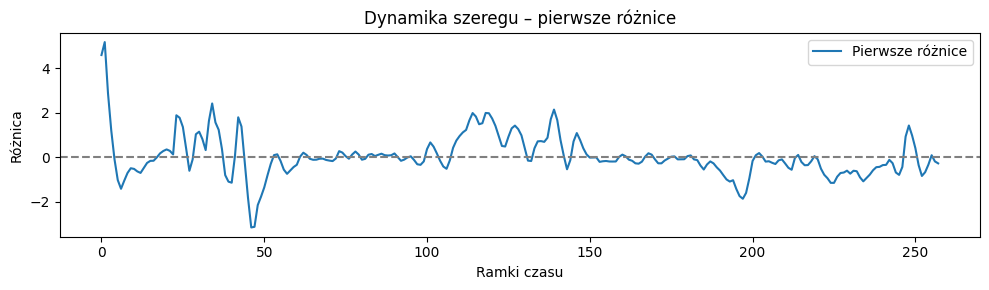

In [5]:
diffs = np.diff(series)

plt.figure(figsize=(10, 3))
plt.plot(diffs, label='Pierwsze różnice')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Dynamika szeregu – pierwsze różnice')
plt.xlabel('Ramki czasu')
plt.ylabel('Różnica')
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.6911812558451869
p-value: 0.4356617912142988


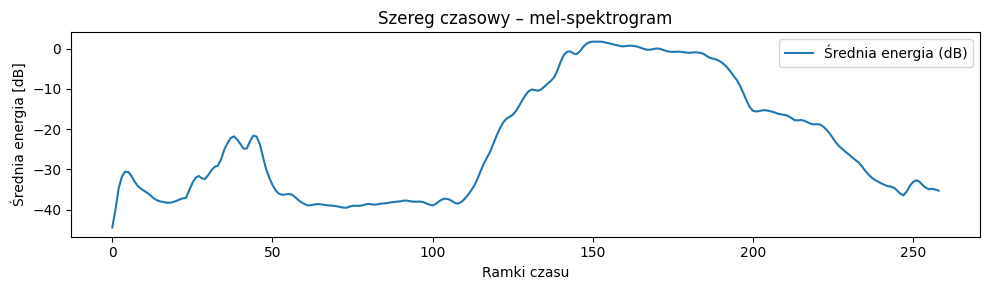

In [7]:
plt.figure(figsize=(10, 3))
plt.plot(series, label='Średnia energia (dB)')
plt.title('Szereg czasowy – mel-spektrogram')
plt.xlabel('Ramki czasu')
plt.ylabel('Średnia energia [dB]')
plt.legend()
plt.tight_layout()
plt.show()


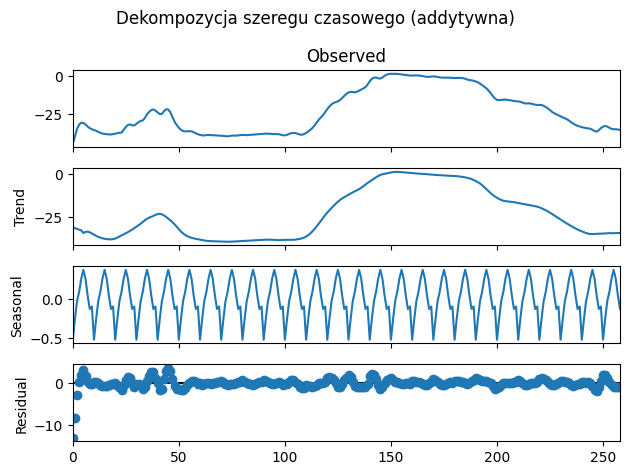

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

series_ts = series

# Dekompozycja addytywna
result = seasonal_decompose(series_ts, model='additive', period=10, extrapolate_trend='freq')

# Wykres
result.plot()
plt.suptitle('Dekompozycja szeregu czasowego (addytywna)')
plt.tight_layout()
plt.show()

# Składowe dostępne jako:
trend = result.trend
seasonal = result.seasonal
residual = result.resid


ADF Statistic: -1.6911812558451869, p-value: 0.4356617912142988
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  259
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -107.338
Date:                Mon, 02 Jun 2025   AIC                            220.677
Time:                        13:07:13   BIC                            231.335
Sample:                             0   HQIC                           224.963
                                - 259                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8069      0.014     57.741      0.000       0.780       0.834
ma.L1          0.6808      0.030     22.500      0.000       0.622 

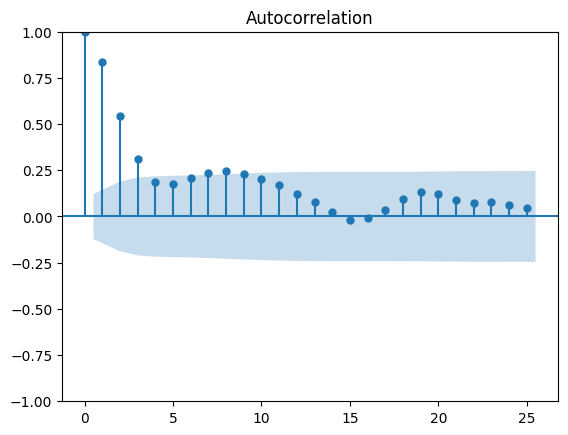

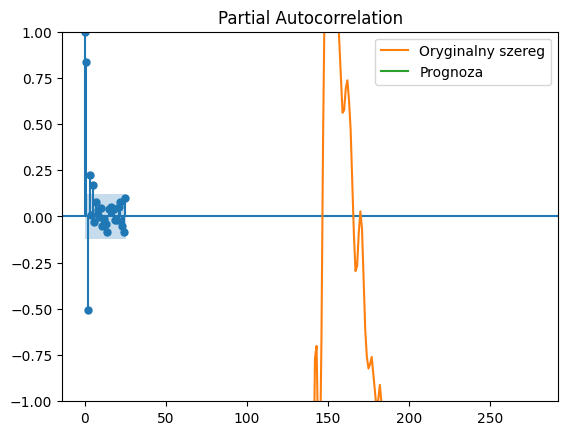

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

result = adfuller(series)
print(f"ADF Statistic: {result[0]}, p-value: {result[1]}")

# Jeśli niestacjonarny, wykonujemy różnicowanie
series_diff = np.diff(series)

plot_acf(series_diff)
plot_pacf(series_diff)

# Budowa modelu ARIMA – załóżmy parametry (1,1,1) po analizie ACF/PACF
model = ARIMA(series, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

# Predykcja
forecast = model_fit.forecast(steps=20)
plt.plot(np.arange(len(series)), series, label='Oryginalny szereg')
plt.plot(np.arange(len(series), len(series) + 20), forecast, label='Prognoza')
plt.legend()
plt.show()
